# SEI (Solid Electrolyte Interface) Builder

<div class="alert alert-block alert-info">
    <table style="border-collapse:collapse; vertical-align:top">
    <col style="width:35%; min-width:150px;"/>
    <col style="width:65%; min-width:200px;"/>
    <tfoot>
        <tr>
            <td style="border-right:2px solid #ffffff; min-width:300px">
                <a href="https://www.big-map.eu/">
                    <img style="width:12%; min-width:25px" src="img/logo-bigmap.png" alt="BIG MAP site" >
                </a>
                <a href="https://areeweb.polito.it/ricerca/small/">
                    <img style="width:50%; min-width:100px" src="img/logo-small.png" alt="SMALL site" >
                </a>
                <a href="https://www.polito.it/">
                    <img style="width:30%; min-width:60px" src="img/logo-polito.png" alt="POLITO site" >
                </a>
            </td>
            <td style="border-collapse:collapse;color:#0097a7; font-size:11pt; text-align:right; min-width:200px">
                <b>Autors:</b><br>            
                Paolo De Angelis (<a href="mailto:paolodeangelis@polito.it">paolodeangelis@polito.it</a>)<br>  
                Roberta Cappabianca (<a href="mailto:roberta.cappabianca@polito.it">roberta.cappabianca@polito.it</a>)<br>  
                Eliodoro Chiavazzo (<a href="mailto:eliodoro.chiavazzo@polito.it">eliodoro.chiavazzo@polito.it</a>)<br>  
                Pietro Asianri (<a href="mailto:pietro.asinari@polito.it">pietro.asinari@polito.it</a>)
            </td>
        </tr>
    </tfoot>
    </table>
</div>

---

**Base Idea**

Reconstruction of SEI by randomly positioning of monocrystal grains in mass proportion from the previous step and from a size distribution (from experiments?).

**Assumptions**
* SEI is made by packing monocrystal grains.
* The grain size follows a given size distribution.
* Each grain shape can be obtained by cutting the supercell with different crystal planes.
* By annealing the system, we will allow the atoms on the grain surfaces to form the "grain bonds."

![Sei builder sketch](img/sei_builder_sketch.png)

## Libraries

In [1]:
import importlib
import os
import sys
from collections import deque

import _pickle as cPickle
import lammps_wrapper.lammps_wrapper as pylmp
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
from ase.lattice.cubic import DiamondFactory
from ase.lattice.hexagonal import HexagonalFactory
from ase.visualize import view
from IPython.display import Markdown, Math, clear_output, display
from lammps_wrapper.lammps_wrapper.packmol import PackmolStructure, packmol
from matplotlib.colors import LinearSegmentedColormap

from seibuilder import (
    from_d_to_grain,
    get_bulk_atoms,
    get_gcd_pedices,
    get_stable_crystal,
    random_sei_grains,
)

output_notebook()

# PACKMOL_BIN = "/opt/packages/packmol/packmol/bin/packmol"  # Workstaion
# PACKMOL_BIN='/m100_work/IscrB_MODLIBAT/software/packmol/packmol'  # Cineca
PACKMOL_BIN = "/work/pr1u1751/pr1u1751/pr1id026/BATTERY/SEI_builder/packmol/packmol"  # Archer2
SEED = 42

ModuleNotFoundError: No module named 'lammps_wrapper'

## Settings

In [ ]:
PACKMOL_BIN = "./packmol/packmol"  # Archer2
SEED = 42

SEI_INFO = pd

## Get Salts

### Lithium fluoride $LiF$ 

In [2]:
LiF_mp, LiF_ase = get_stable_crystal("LiF")

In [3]:
v = view(LiF_ase, viewer="ngl")
v.view.clear()
v.view.add_ball_and_stick(LiF_ase)
v.view.add_unitcell(LiF_ase)
v.view.display(gui=False)
v

### Lithium carbonate $Li_2CO_3$

In [4]:
Li2CO3_mp, Li2CO3_ase = get_stable_crystal("Li2CO3")

In [5]:
v = view(Li2CO3_ase, viewer="ngl")
v.view.clear()
v.view.add_ball_and_stick(Li2CO3_ase)
v.view.add_unitcell(Li2CO3_ase)
v.view.display(gui=False)
v

### Lithium superoxide $Li_2O$

In [6]:
Li2O_mp, Li2O_ase = get_stable_crystal("Li2O")

In [7]:
v = view(Li2O_ase, viewer="ngl")
v.view.clear()
v.view.add_ball_and_stick(Li2O_ase)
v.view.add_unitcell(Li2O_ase)
v.view.display(gui=False)
v

## Random sempling

### Set up sampling space

In [8]:
from numpy.random import PCG64, Generator, RandomState

pcg64 = PCG64(seed=SEED)
rg = Generator(pcg64)
rg.standard_normal()

global d_mean
global d_std

d_mean = [15.0, 13.0, 10.0]
d_std = [3, 3, 2]


def np_d_0():
    d_mean_ = d_mean[0]
    d_std_ = d_std[0]
    i = 0
    d = rg.normal(loc=d_mean_, scale=d_std_, size=1)[0]
    return d


def np_d_1():
    d_mean_ = d_mean[1]
    d_std_ = d_std[1]
    i = 0
    d = rg.normal(loc=d_mean_, scale=d_std_, size=1)[0]
    return d


def np_d_2():
    d_mean_ = d_mean[2]
    d_std_ = d_std[2]
    i = 0
    d = rg.normal(loc=d_mean_, scale=d_std_, size=1)[0]
    return d

### SEI's grains sempling

In [9]:
Natoms = 5000
surfaces_all = [(1, 0, 0), (1, 1, 0), (1, 1, 1), (1, 2, 0), (1, 3, 0), (1, 2, 1), (1, 3, 1)]
random_sampler = [np_d_0, np_d_1, np_d_2]
species = [LiF_mp, Li2CO3_mp, Li2O_mp]
species_fractions = np.array([24, 7, 4])  # [N molecules] LiF, Li2CO3, Li2O
molecules_in_unit_cell = np.array([get_gcd_pedices(i.formula) for i in species])

out_species, out_d, out_vol, out_species_fraction, out_clust = random_sei_grains(
    Natoms,
    species_fractions,
    molecules_in_unit_cell,
    random_sampler,
    species,
    species_fraction_tol=0.05,
    Ngrains_max=500,
    surfaces_all=surfaces_all,
    n_surfaces=2,
    seed=SEED,
)

/lus/cls01095/work/pr1u1751/pr1u1751/pr1id026/venv_sei/lib/python3.7/site-packages/mpinterfaces/nanoparticle.py:48: FutureWarning: species_and_occu is deprecated
Use site.species instead. This will be deprecated with effect from pymatgen 2020.
  for sn in spherical_neighbors],


[W]: [23:50:15 BST] Nanoparticle 13 rejected since exceed the total numebr of atoms allow for specie Li1 F1                                                           
[W]: [23:50:31 BST] Nanoparticle 25 rejected since exceed the total numebr of atoms allow for specie Li4 C2 O6                                                        
[W]: [23:50:32 BST] Nanoparticle 26 rejected since exceed the total numebr of atoms allow for specie Li4 C2 O6                                                        
[W]: [23:50:37 BST] Nanoparticle 27 rejected since exceed the total numebr of atoms allow for specie Li2 O1                                                           
[I]: [23:50:37 BST] END                                                                                                                                                   


Seve the results (as pickle)

In [10]:
with open(os.path.join("data", "0-grain_list.pkl"), "wb") as file_:
    cPickle.dump([out_species, out_d, out_vol, out_species_fraction, out_clust], file_)

### Final result Analisys 

Load result from previus step

In [11]:
with open(os.path.join("data", "0-grain_list.pkl"), "rb") as file_:
    out_species, out_d, out_vol, out_species_fraction, out_clust = cPickle.load(file_)

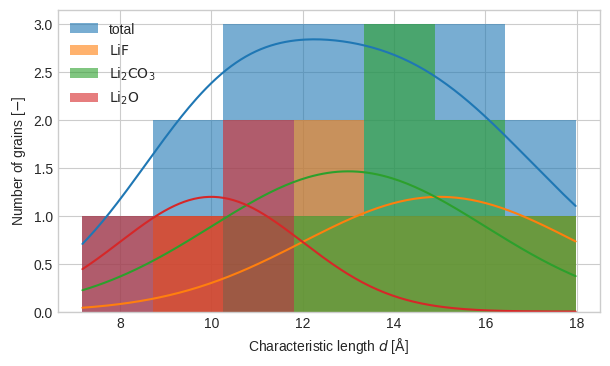

In [12]:
plt.style.use("seaborn-whitegrid")
fig1 = plt.figure(figsize=[7, 4], dpi=100)
ax = fig1.add_subplot(111)

labels = [r"$\mathrm{LiF}$", r"$\mathrm{Li_2CO_3}$", r"$\mathrm{Li_2O}$"]
bins = np.linspace(out_d.min(), out_d.max(), 8)
d_x = np.linspace(out_d.min(), out_d.max(), 200)
hist_d, _ = np.histogram(out_d, bins=bins, density=True)
ax.bar(bins[:-1], np.round(hist_d * len(out_species)), width=bins[1] - bins[0], align="edge", label="total", alpha=0.6)
tot_dist = np.zeros(len(d_x))
for i in np.unique(out_species):
    tot_dist += stats.norm.pdf(d_x, d_mean[i], d_std[i]) * np.sum(out_species == i)
ax.plot(d_x, tot_dist)

for i in np.unique(out_species):
    hist_d, _ = np.histogram(out_d[out_species == i], bins=bins, density=True)
    ax.bar(
        bins[:-1],
        np.round(hist_d * np.sum(out_species == i)),
        width=bins[1] - bins[0],
        align="edge",
        label=labels[i],
        alpha=0.6,
    )
    ax.plot(d_x, stats.norm.pdf(d_x, d_mean[i], d_std[i]) * np.sum(out_species == i))

ax.legend()
ax.set_xlabel(r"Characteristic length $d$ [$\mathrm{\AA}$]")
ax.set_ylabel("Number of grains [$-$]")
plt.show()
fig1.savefig(os.path.join("plots", "fig1-grain_distributions.png"), bbox_inches="tight", dpi=300)

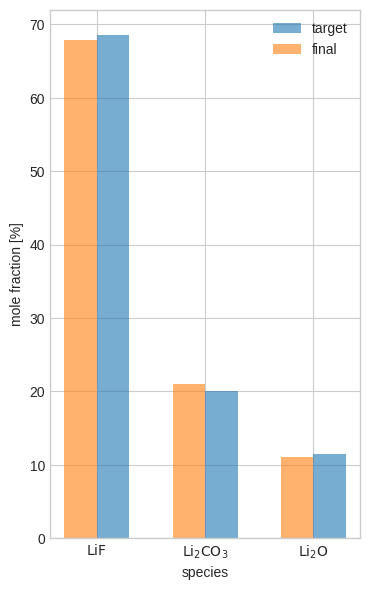

In [13]:
plt.style.use("seaborn-whitegrid")
fig2 = plt.figure(figsize=[4, 7], dpi=100)
ax = fig2.add_subplot(111)

labels = [r"$\mathrm{LiF}$", r"$\mathrm{Li_2CO_3}$", r"$\mathrm{Li_2O}$"]
x = np.arange(len(out_species_fraction))
ax.bar(x + 0.15, species_fractions / species_fractions.sum() * 100, width=0.3, label="target", alpha=0.6)
ax.bar(x - 0.15, out_species_fraction * 100, width=0.3, label="final", alpha=0.6)

ax.legend()
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_xlabel("species")
ax.set_ylabel("mole fraction [%]")
plt.show()
fig2.savefig(os.path.join("plots", "fig2-grain_mole_fraction.png"), bbox_inches="tight", dpi=300)

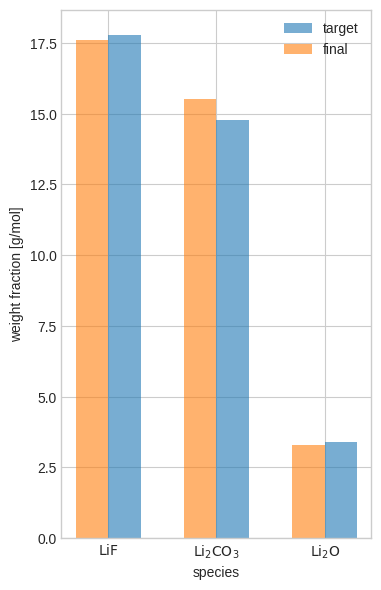

In [14]:
mass = np.array([np.sum(LiF_ase.get_masses()), np.sum(Li2CO3_ase.get_masses()), np.sum(Li2O_ase.get_masses())])
mass = mass / molecules_in_unit_cell
atoms_in_unit_cell = np.array([len(i.sites) for i in species])
out_atoms = np.zeros(len(np.unique(out_species)))

for i in np.unique(out_species):
    for particle in out_clust[out_species == i]:
        out_atoms[i] += len(particle)
        out_mass_fraction = out_atoms / atoms_in_unit_cell * molecules_in_unit_cell
out_mass_fraction = out_mass_fraction / out_mass_fraction.sum() * mass

plt.style.use("seaborn-whitegrid")
fig3 = plt.figure(figsize=[4, 7], dpi=100)
ax = fig3.add_subplot(111)

labels = [r"$\mathrm{LiF}$", r"$\mathrm{Li_2CO_3}$", r"$\mathrm{Li_2O}$"]
x = np.arange(len(out_species_fraction))
ax.bar(x + 0.15, species_fractions / species_fractions.sum() * mass, width=0.3, label="target", alpha=0.6)
ax.bar(x - 0.15, out_mass_fraction, width=0.3, label="final", alpha=0.6)

ax.legend()
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_xlabel("species")
ax.set_ylabel("weight fraction [g/mol]")
plt.show()
fig3.savefig(os.path.join("plots", "fig3-grain_weight_fraction.png"), bbox_inches="tight", dpi=300)

## Get additional characteristics

### Bonds

We esteem the bond in the system using Modified Shoemaker and Stevenson equation (https://doi.org/10.1016/0022-2860(85)85036-5)

In [15]:
out_clust_with_bonds = []

for clust_ in out_clust:
    # convert to System
    out_clust_with_bonds.append(System())
    out_clust_with_bonds[-1].from_atoms(clust_)
    # get bonds
    out_clust_with_bonds[-1].get_bonds(n_jobs=4, tol=0.1, ignore_molecules=True, verbose=2)

### Surface Atoms

In [16]:
for clust_ in out_clust_with_bonds:
    bulk_atoms, score = get_bulk_atoms(clust_, strategy="coordination", method="cutoff", threshold=0.5)
    clust_.info["bulk_atoms"] = bulk_atoms
    clust_.info["bulk_atoms_score"] = score

Visualize

In [17]:
from ase import Atoms

clust_ = out_clust_with_bonds[11]
positions = clust_.get_positions()
symbols = ["C" if x else "O" for x in clust_.info["bulk_atoms"]]
col_clust = Atoms(symbols=symbols, positions=positions)

v = view(col_clust, viewer="ngl")
v.view.clear()
v.view.add_ball_and_stick(col_clust)
v.view.add_unitcell(col_clust)
v.view.display(gui=False)
v

Seve the results (as pickle)

In [18]:
with open(os.path.join("data", "1-grain_list_with_bonds.pkl"), "wb") as file_:
    cPickle.dump([out_species, out_d, out_vol, out_species_fraction, out_clust_with_bonds], file_)

## Pack all

### Load `Lammps wrapper`

In [2]:
# SMaLL's WorkStation
# module_stg = {"load": "lammps/29Oct2020_kokkos_python"}
# slurm_stg = {"--partition=": "small", "--time=": "240:00:00"}
# Maroconi100 HPC @ Cineca
# module_stg = {"purge":"",
#              "load": ["profile/chem-phys", "autoload lammps/3mar2020"]}
# slurm_stg = {"--partition=": "m100_usr_prod",
#             "--qos=": "m100_qos_dbg",
#             "--time=": "24:00:00",
#             "--mem=": "20000MB",
#             "--account=": "IscrB_MODLIBAT"}
# ARCHER2 HPC @ epcc.ed.ac.uk
module_stg = {"load": ["epcc-job-env", "lammps"]}
slurm_stg = {
    "--partition=": "standard",
    "--qos=": "standard",  # or short, or long
    "--time=": "24:00:00",
    "--account=": "pr1u1751",
}
pylmp.lammps.set_jobs_settings(slurm=slurm_stg, module=module_stg, verbose=2)

[I]: Read old settings file .lammps_wrapper/job_settings.json
[I]: JOB settings file saved in .lammps_wrapper/job_settings.json


True

In [3]:
lammps = pylmp.lammps.LAMMPS(lmp_cmd="lmp", mpi_cmd="srun", verbose=3)

[I]: Found configuration file .lammps_wrapper/job_settings.json in the hidden folder .lammps_wrapper
[W]: There is not the user info file .lammps_wrapper/user.json in the hidden folder .lammps_wrapper
[W]: Please use the function `lammps_wrapper.lammps.set_user()` to set-up the USER
[I]: User: pr1id026
[I]: Script save in run_None.sh
[I]: Script save in run_None.sh
[W]: Timeout!
[W]: Was impossible to run the cmd `mpirun -n 1 lmp -help`
[I]: Script save in run_None.sh
[I]: Script save in run_None.sh
[I]: image: lammps_wrapper/lammps_wrapper/img/logo.png
[I]: msg: <IPython.core.display.HTML object>


### Build Anode

#### $C_6$ Anode

In [5]:
class GrFactory(HexagonalFactory):  # make a new crsital object from the HexagonalFactory
    "A factory for creating Graphite lattices."
    xtal_name = "graphite"
    bravais_basis = [[0, 0, 0], [1.0 / 3.0, 2.0 / 3.0, 0], [1.0 / 3.0, 2.0 / 3.0, 0.5], [2.0 / 3.0, 1.0 / 3.0, 0.5]]

In [6]:
Gr = GrFactory()
a = 2.461  # [Å]
c = 6.708  # [Å]
Lx, Ly, Lz = [35.0, 35.0, 20.0]  # [Å]
Nx, Ny, Nz = [int(np.round(Lx / c)), int(np.round(Ly / a)), int(np.round(Lz / a / 3**0.5))]
GrAnode = Gr(
    latticeconstant={"a": 2.461, "c": 6.708},
    symbol="C",
    size=(Nx, Ny, Nz),
    directions=[[0, 0, 0, 1], [1, -2, 1, 0], [1, 0, -1, 0]],
    pbc=True,
)
GrAnode.info["name"] = "Anode"
GrAnode.cell

Cell([33.54, 34.454, 21.312885187135038])

In [7]:
v = view(GrAnode, viewer="ngl")
v.view.clear()
v.view.add_ball_and_stick(GrAnode)
v.view.add_unitcell(GrAnode)
v.view.display(gui=False)
v

#### $SI$ Anode

In [8]:
Diamond = DiamondFactory()
a = 5.43  # [Å]
Nslab = 18
da_z = a / 4
Lx, Ly, Lz = [35.0, 35.0, 5 * a]  # [Å]
Nx, Ny, Nz = [int(np.round(Lx / a * 2**0.5)), int(np.round(Ly / a * 2**0.5)), int(np.round(Lz / a))]
# Nx, Ny, Nz = [9, 9, 5]
SiAnode = Diamond(
    latticeconstant=a, symbol="Si", size=(Nx, Ny, Nz), directions=[[1, 1, 0], [-1, 1, 0], [0, 0, 1]], pbc=True
)
SiAnode.info["name"] = "Anode"
SiAnode.cell

Cell([34.55630839658657, 34.55630839658657, 27.15])

In [9]:
v = view(SiAnode, viewer="ngl")
v.view.clear()
v.view.add_ball_and_stick(SiAnode)
v.view.add_unitcell(SiAnode)
v.view.display(gui=False)
v

### Pack SEI grains

In [10]:
# Choose a Anode
ANODE = SiAnode  # or GrAnode

In [17]:
porosity = 3
tot_vol = out_vol.sum() * (1 + porosity)
lc, wc, hc = ANODE.get_cell().diagonal()  # [Å]
clearance = 4  # [Å]
box = [lc, wc, tot_vol / (lc - clearance) / (wc - clearance) + clearance]
box

[34.55630839658657, 34.55630839658657, 72.38153131148434]

In [18]:
tolerance = 2.5
SEI_box = packmol(
    [
        PackmolStructure(
            cluster,
            number=1,
            instructions=[
                "inside box {:.16f} {:.16f} {:.16f} {:.16f} {:.16f} {:.16f}".format(
                    clearance / 2,
                    clearance / 2,
                    clearance / 2,
                    box[0] - clearance / 2,
                    box[1] - clearance / 2,
                    box[2] - clearance / 2,
                )
            ],
        )
        for cluster in out_clust
    ],
    packmol_bin=PACKMOL_BIN,
    verbose=2,
    n_lines=20,
    cell=box,
    tolerance=tolerance,
    nloop=100,
    seed=SEED,  # maxit=50,#, maxit=100,  cell=box_size,
)

[I]: [14:56:20 BST]               Please cite this work if Packmol was useful: 
[I]: [14:56:20 BST] 
[I]: [14:56:20 BST]            L. Martinez, R. Andrade, E. G. Birgin, J. M. Martinez, 
[I]: [14:56:20 BST]          PACKMOL: A package for building initial configurations for
[I]: [14:56:20 BST]                    molecular dynamics simulations. 
[I]: [14:56:20 BST]           Journal of Computational Chemistry, 30:2157-2164,2009.
[I]: [14:56:20 BST] 
[I]: [14:56:20 BST] ################################################################################
[I]: [14:56:20 BST] 
[I]: [14:56:20 BST]   Solution written to file: output.xyz
[I]: [14:56:20 BST] 
[I]: [14:56:20 BST] --------------------------------------------------------------------------------
[I]: [14:56:20 BST] 
[I]: [14:56:20 BST]    Running time:    3.30092478      seconds. 
[I]: [14:56:20 BST] 
[I]: [14:56:20 BST] --------------------------------------------------------------------------------
[I]: [14:56:20 BST] 
[I]: [14:56:2

In [20]:
v = view(SEI_box, viewer="ngl")
v.view.clear()
v.view.add_ball_and_stick(SEI_box)
v.view.add_unitcell(SEI_box)
v.view.display(gui=False)
v

#### Compute bonds

We esteem the bond in the system using Modified Shoemaker and Stevenson equation (https://doi.org/10.1016/0022-2860(85)85036-5)

In [87]:
SEI_box.get_bonds(n_jobs=4, tol=0.1, verbose=2)

In [88]:
bond_matrix = SEI_box.get_bond_matrix()

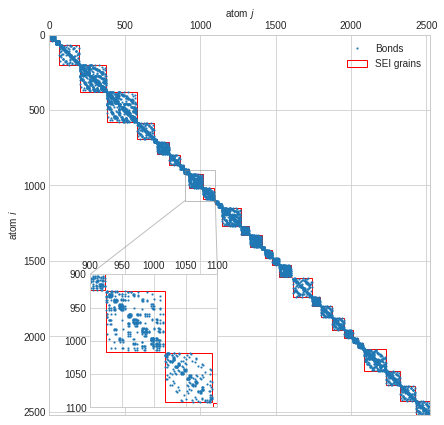

In [89]:
fig4 = plt.figure(figsize=[7, 7])
ax = fig4.add_subplot(111)
ax_zoom = ax.inset_axes([0.1, 0.02, 0.35, 0.35])
ax.spy(bond_matrix, markersize=1, label="Bonds")
ax_zoom.spy(bond_matrix, markersize=1)
# add grains border:
for atoms_list in SEI_box.molecules_index:
    i_min = np.min(atoms_list)
    i_max = np.max(atoms_list)
    square = plt.Rectangle((i_min, i_min), i_max - i_min, i_max - i_min, fc="none", ec="red")
    ax.add_patch(square)
    square = plt.Rectangle((i_min, i_min), i_max - i_min, i_max - i_min, fc="none", ec="red")
    ax_zoom.add_patch(square)
ax_zoom.set_ylim([1100, 900])
ax_zoom.set_xlim([900, 1100])
ax.indicate_inset_zoom(ax_zoom)
handles, labels = ax.get_legend_handles_labels()
handles[-1] = plt.Rectangle((0, 0), 0, 0, fc="none", ec="red")
labels[-1] = "SEI grains"
ax.legend(handles, labels)
ax.set_xlabel("atom $j$")
ax.xaxis.set_label_position("top")
ax.set_ylabel("atom $i$")
plt.show()
fig4.savefig(os.path.join("plots", "fig4-SEI_initial_configuration_bond-matrix.png"), bbox_inches="tight", dpi=300)

Save the graphite ans SEI strucure before any simulation

In [90]:
SEI_box.save(os.path.join("data", "1-SEI_initial_comf.pkl"))

## Compacting

Reload the initial configuration

In [2]:
SEI_box = System()
SEI_box.load(os.path.join("data", "1-SEI_initial_comf.pkl"))

### Load `Lammps wrapper`

In [42]:
# SMaLL's WorkStation
# module_stg = {"load": "lammps/29Oct2020_kokkos_python"}
# slurm_stg = {"--partition=": "small",     "--time=": "240:00:00"}
# Cineca HPC
module_stg = {"purge": "", "load": ["profile/chem-phys", "autoload lammps/3mar2020"]}
slurm_stg = {
    "--partition=": "m100_usr_prod",
    "--qos=": "m100_qos_dbg",
    "--time=": "2:00:00",
    "--mem=": "10000MB",
    "--account=": "IscrB_MODLIBAT",
}
pylmp.lammps.set_jobs_settings(slurm=slurm_stg, module=module_stg, verbose=2)

[I]: Read old settings file .lammps_wrapper/job_settings.json
[I]: JOB settings file saved in .lammps_wrapper/job_settings.json


True

In [44]:
lammps = pylmp.lammps.LAMMPS(lmp_cmd="lmp_mpi", mpi_cmd="mpirun", verbose=2)

[I]: Found configuration file .lammps_wrapper/job_settings.json in the hidden folder .lammps_wrapper
[I]: Found user info file .lammps_wrapper/user.json in the hidden folder .lammps_wrapper
[I]: User: pdeangel (paolo.deangelis@polito.it)
[I]: Script save in run_None.sh
[I]: Script save in run_None.sh


### Load Reax FF

Load Reax Force Fiels

In [26]:
reaxff = pylmp.ff.ReaxFF()
reaxff(os.path.join("data", "ffield.reax"))
# Add ReaxFF info
reaxff.ff_authors = ["Sang Soo Han"]
reaxff.ff_year = "2015"
reaxff.ff_doi = "http://battery.vfab.org/wiki/index.php/Anode_Materials_Design_Lab#Interatomic_Potential"
reaxff

--- ReaxFF C/H/O/Si/Al/Li/F/P/B ------------------------------------------------
    * 39 General Parameters:	 object.general.parm < pandas.DataFrame >
                         	 object.general.info < dict >
    * 9 Atoms X 32 Parameters:	 object.atoms.parm < pandas.DataFrame >
                         	 object.atoms.info < dict >
    * 38 Bonds X 16 Parameters:	 object.bonds.parm < pandas.DataFrame >
                         	 object.bonds.info < dict >
    * 29 VanDerWaals X 6 Parameters:	 object.vanderwaals.parm < pandas.DataFrame >
                         	 object.vanderwaals.info < dict >
    * 83 Angles X 7 Parameters:	 object.angles.parm < pandas.DataFrame >
                         	 object.angles.info < dict >
    * 50 Torsions X 7 Parameters:	 object.torsions.parm < pandas.DataFrame >
                         	 object.torsions.info < dict >
    * 2 HBonds X 4 Parameters:	 object.hbonds.parm < pandas.DataFrame >
                         	 object.hbonds.info < dict >
---------

Open a project

In [45]:
lammps.open_project(working_dir="simulations", project_name="SEI_builder", verbose=0)
project = lammps.projects[-1]
print(project)

[I]: Project Loaded       ████████████████████████████████████████████████████████████████████████ 100.0%
--- PROJECT --------------------------------------------------------------------
 Name:              SEI_builder
 Working Directory: simulations
 UUID:              50998144-b937-4cf1-9045-18ba90eb77bc
 Date:              26/04/2021 21:03:07 
 Simulations:       1
--------------------------------------------------------------------------------


### Energy minimization

In [10]:
# Uncomet if you not have the simulation in the folder
# project.make_simulation(working_dir=os.path.join(project.working_dir, 'compacting', 'EM'),
#                         simulation_name='Compacting/EM', verbose=2)

[I]: Folder /m100_work/IscrB_MODLIBAT/pdeangel/BATTERY/SEI_builder/simulations/compacting maked
[I]: Folder /m100_work/IscrB_MODLIBAT/pdeangel/BATTERY/SEI_builder/simulations/compacting/EM maked
[I]: Simulation metadata updated
[I]: Simulation successfully created
[I]: Project metadata saved in simulations/project_metadata.json
[I]: Simulation successfully created!
[I]: Call `Simulation` method `Simulation.checklist()` to a get the next step before to run the it


Simulation object uuid:a2550950-d689-42d8-9771-29c5591b0d7b at 0x7fff490e2370

In [12]:
project.show()

TREE                          ID  UUID                                    INFO                      
----------------------------------------------------------------------------------------------------
Project: SEI_builder (1 simulations)
└──Compacting                                                                                       
    └──EM                     0   a2550950-d689-42d8-9771-29c5591b0d7b    NR (NO_READY)             



In [46]:
em_simulation = project.get_simulation(name="Compacting/EM")[0]

What we have to do:

In [17]:
em_simulation.check_list()

  ☑	Create simulation and its metadata.
  ☐	Add Simulation System:
   	Create and load the system with the `Simulation` class method `add_input` (`Simulation.add_input()) e.g.:
   		•  From a LAMMPS formatted file:
   		   >>> simulation.add_input(system='/Path/to/system_file.in')
   		•  From using ASE Atoms Object and the right Force Field Object:
   		   >>> mol = ase.atoms(...)
   		   >>> reaxff = lammps_wrapper.ff.ReaxFF(...)
   		   >>> simulation.add_input(system=mol, ff=reaxff))
  ☐	Add LAMMPS input script:
   	Create or load the LAMMPS script with class method `add_inputs` (`Simulation.add_inputs()) e.g.:
   		•  From a file:
   		   >>> simulation.add_input(input_script='/Path/to/input_file.in')
   		•  From using a dictionary with the parameters:
   		   >>> parameters = dict(units='real', atom_style='charge'
   		                         read_data=data_file_path, ...)
   		   >>> simulation.add_input(parameters=parameters)
  ☐	(Optional) Other inputs file:
   	Add file wit

**ADD**: Input data file and reaxff

In [19]:
em_simulation.add_input(system=SEI_box, ff=reaxff, atom_style="full", verbose=1)

[I]: User: pdeangel (paolo.deangelis@polito.it)
[I]: LAMMPS input data file save in /m100_work/IscrB_MODLIBAT/pdeangel/BATTERY/SEI_builder/simulations/compacting/EM/data.system 
[I]: LAMMPS input data file save in /m100_work/IscrB_MODLIBAT/pdeangel/BATTERY/SEI_builder/simulations/compacting/EM/data.system 
[I]: System LAMMPS input write in /m100_work/IscrB_MODLIBAT/pdeangel/BATTERY/SEI_builder/simulations/compacting/EM/data.system
[I]: Saved System python object in /m100_work/IscrB_MODLIBAT/pdeangel/BATTERY/SEI_builder/simulations/compacting/EM/data.system.pkl
[I]: Saved System python object in /m100_work/IscrB_MODLIBAT/pdeangel/BATTERY/SEI_builder/simulations/compacting/EM/data.system.pkl
[I]: ReaxFF input file save in /m100_work/IscrB_MODLIBAT/pdeangel/BATTERY/SEI_builder/simulations/compacting/EM/ff.forcefield 
[I]: ReaxFF (Reactive Force Field) (Force Field) saved in /m100_work/IscrB_MODLIBAT/pdeangel/BATTERY/SEI_builder/simulations/compacting/EM/ff.forcefield
[I]: Simulation metad

**ADD**: Input script

In [57]:
from simulation_settings import default_em

parameters_em = default_em.copy()
parameters_em.update(
    dict(
        read_data=em_simulation.files["input_system"],
        pair_coeff="* * {} {}".format("ff.forcefield", " ".join(reaxff.elements)),
        minimize="0.0 50 10000 3000",
    )
)
em_simulation.add_input(parameters=parameters_em, verbose=2)

[I]: control file save in /m100_work/IscrB_MODLIBAT/pdeangel/BATTERY/SEI_builder/simulations/compacting/EM/control.pair_style 
[W]: The following LAMMPS input commands will write in input file, but are not implemented yet
[W]: into the python wrapper:
[I]: LAMMPS input file save in /m100_work/IscrB_MODLIBAT/pdeangel/BATTERY/SEI_builder/simulations/compacting/EM/in.simulation
[I]: log output style = `step temp pe etotal press vol fmax fnorm`
[I]: Simulation steps 10000 with a timestep None
[I]: Simulation metadata updated
[I]: Simulation metadata updated


In [29]:
em_simulation.check_list()

  ☑	Create simulation and its metadata.
  ☑	Add Simulation System:
   	Create and load the system with the `Simulation` class method `add_input` (`Simulation.add_input()) e.g.:
   		•  From a LAMMPS formatted file:
   		   >>> simulation.add_input(system='/Path/to/system_file.in')
   		•  From using ASE Atoms Object and the right Force Field Object:
   		   >>> mol = ase.atoms(...)
   		   >>> reaxff = lammps_wrapper.ff.ReaxFF(...)
   		   >>> simulation.add_input(system=mol, ff=reaxff))
  ☑	Add LAMMPS input script:
   	Create or load the LAMMPS script with class method `add_inputs` (`Simulation.add_inputs()) e.g.:
   		•  From a file:
   		   >>> simulation.add_input(input_script='/Path/to/input_file.in')
   		•  From using a dictionary with the parameters:
   		   >>> parameters = dict(units='real', atom_style='charge'
   		                         read_data=data_file_path, ...)
   		   >>> simulation.add_input(parameters=parameters)
  ☐	(Optional) Other inputs file:
   	Add file wit

In [58]:
em_simulation.run(
    mpi=128, omp=1, gpus=None, nodes=1, ntasks_per_node=128, cpus_per_task=None, follow=False, plot=False, verbose=1
)

In [1]:
128 / 2

64.0

In [59]:
em_simulation.show(plot=True, verbose=2, ypos=["etotal", "fnorm"], plot_window=100)

[I]: [21:40:24 CEST] Job 2931157 is RUNNING                                                              
[I]: I cannot find the actual step by looking at output file (/m100_work/IscrB_MODLIBAT/pdeangel/BATTERY/SEI_builder/simulations/compacting/EM/output-Compacting_EM-2931157.out)


FloatProgress(value=0.0, bar_style='info', description=' 0.00%', layout=Layout(width='900px'))

[I]: [21:54:29 CEST] Simulation `Compacting/EM` COMPLETED!


load results

In [79]:
out = reaxff.read_and_convert_dump(
    os.path.join(simulation.working_dir, simulation.files["output_dump"]), index=-1, ncores=12
)
out.set_pbc(True)
# Store in a System(Atoms) object with the moleculicense
SEI_em = System()
SEI_em.from_atoms(out)
SEI_em.set_molecules(SEI_box.molecules_index, molecule_names=SEI_box.molecules_name)

NameError: name 'simulation' is not defined

In [ ]:
v = view(SEI_em, viewer="ngl")
v.view.clear()
v.view.add_ball_and_stick(SEI_em)
v.view.add_unitcell(SEI_em)
v.view.display(gui=True)
v

Save the graphite ans SEI strucure after energy minimization

In [12]:
SEI_em.save(os.path.join("data", "2-SEI_energy_minimization.pkl"))